# Holistic Results

**TODO**: Fill in the `MRMC_DIR`. This should be a path (absolute or relative) to the repo's top-level directory. It is probably `../../../..`

In [3]:
import sys
import os

MRMC_DIR = '../../../..'

if MRMC_DIR is None:
    raise RuntimeError("MRMC_DIR should have the path to the top-level directory of the MRMC repo.")

In [4]:
sys.path.append(MRMC_DIR)

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns

from scripts import fit_kde
from models import model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminaries -- load everything

**TODO**: fill in values for `RECOURSE_METHOD`, `DATASET`, and `MODEL`.

In [5]:
RECOURSE_METHOD = 'face'  # mrmc, dice, or face
DATASET_NAME = 'credit_card_default'  # credit_card_default or give_me_credit
MODEL_TYPE = 'logistic_regression'  # logistic_regression or random_forest
EXPERIMENT_NAME = f"{RECOURSE_METHOD}_holistic"
RESULTS_DIR = os.path.join(MRMC_DIR, 'experiment_results', RECOURSE_METHOD, MODEL_TYPE, DATASET_NAME, EXPERIMENT_NAME)

if None in [RECOURSE_METHOD, DATASET_NAME, MODEL_TYPE]:
    raise RuntimeError("Values for RECOURSE_METHOD, DATASET, and MODEL must be provided.")

In [6]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName(DATASET_NAME), split="train")
MODEL = model_loader.load_model(model_constants.ModelType(MODEL_TYPE), data_loader.DatasetName(DATASET_NAME))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

DROP_COLUMNS = ['step_id', 'path_id', 'run_id', 'batch_id']  # columns which are convenient to drop from the path_df

with open(os.path.join(RESULTS_DIR, 'config.json')) as f:
    config_json = json.load(f)

EVAL_SPLIT = config_json['split']
EVAL_DATASET, _ = data_loader.load_data(data_loader.DatasetName(DATASET_NAME), split=EVAL_SPLIT)


#  If using MRMC, load the cluster DF
if RECOURSE_METHOD == 'mrmc':
    cluster_df = pd.read_csv(os.path.join(RESULTS_DIR, 'cluster_df.csv'))
config_df = pd.read_csv(os.path.join(RESULTS_DIR, 'experiment_config_df.csv'))
#  If using FACE, retrieve the distance_threshold and weight_bias from the graph config
if RECOURSE_METHOD == 'face':
    graph_filepaths = config_df.graph_filepath.unique()
    distance_thresholds = []
    weight_biases = []
    for graph_filepath in graph_filepaths:
        graph_config_filepath = os.path.join(MRMC_DIR, graph_filepath[:-4] + '_config.json')
        with open(graph_config_filepath) as f:
            graph_config = json.load(f)
            distance_thresholds.append(graph_config['distance_threshold'])
            weight_biases.append(graph_config['weight_bias'])
    graph_config_df = pd.DataFrame({
        'graph_filepath': graph_filepaths,
        'distance_threshold': distance_thresholds,
        'weight_bias': weight_biases
    })
    config_df = config_df.merge(graph_config_df, how='left', on='graph_filepath')
path_df = pd.read_csv(os.path.join(RESULTS_DIR, f'{RECOURSE_METHOD}_paths_df.csv'))
config_df

,batch_id,run_id,run_seed,confidence_cutoff,counterfactual_mode,graph_filepath,max_iterations,noise_ratio,num_paths,poi_index,rescale_ratio,elapsed_recourse_seconds,distance_threshold,weight_bias
0,406,406,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,4096,NaN,2.696004,2.5,1.012
1,602,602,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,22700,NaN,2.438018,2.5,1.012
2,1072,1072,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,6541,NaN,2.115067,2.5,1.012
3,949,949,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,27111,NaN,2.155962,2.5,1.012
4,768,768,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,27299,NaN,2.112771,2.5,1.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,919,919,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,26890,NaN,2.346878,2.5,1.012
1120,74,74,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,11869,NaN,2.346497,2.5,1.012
1121,1037,1037,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,26716,NaN,2.010897,2.5,1.012
1122,446,446,7527,0.7,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,15852,NaN,3.026057,2.5,1.012


## Load or Fit a KDE

In [7]:
KDE_DIRECTORY = os.path.join(MRMC_DIR, f'saved_models/kde/{DATASET_NAME}_kde.joblib')

if os.path.exists(KDE_DIRECTORY):
    KDE = joblib.load(KDE_DIRECTORY)
else:
    KDE = fit_kde.fit_kde(DATASET_NAME, KDE_DIRECTORY)

# Analyze the results

**TODO**: Provide a value for `USE_CACHED_RESULTS`. If you have recently rerun
the experiment, you probably don't want to use a cached analysis.

In [8]:
SPARSITY_EPSILON = 1e-5
USE_CACHED_RESULTS = True

def get_poi_cfes(path_df: pd.DataFrame):
    """Isolate the POIs (Points of Interest) and CFEs (Counterfactual Examples) from the full path results.
    
    POIs and CFEs are listed in the order they originally appear in. There is one POI and one CFE
    for every path that appears in the DataFrame."""
    pathscopy = path_df.copy()
    pathscopy['next_step_id'] = 0
    pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]
    cfes = pathscopy[pathscopy.step_id >= pathscopy.next_step_id].drop(columns='next_step_id')
    return pathscopy[pathscopy.step_id == 0].drop(columns='next_step_id'), cfes

def get_sparsity(path: pd.DataFrame):
    """Returns the maximum number of features changed in any single iteration
    along the path."""
    if path.shape[0] == 1:
        return np.nan
    path_sparsity = np.zeros(path.shape[0])
    for i in range(1, path.shape[0]):
        path_sparsity[i] = (np.abs(path.iloc[i] - path.iloc[i - 1]) > SPARSITY_EPSILON).sum()
    return np.max(path_sparsity)

def get_path_length(path: pd.DataFrame):
    """Returns the sum of euclidean distances along the path."""
    total = 0
    for i in range(1, path.shape[0]):
        total += np.linalg.norm(path.iloc[i] - path.iloc[i - 1])
    if total == 0:
        return np.nan
    return total

def get_cfe_distance(path: pd.DataFrame):
    """Returns the euclidean distance between the first and last points in the path."""
    if len(path) == 1:
        return np.nan
    return np.linalg.norm(path.iloc[-1] - path.iloc[0])


def analyze_paths(paths: pd.DataFrame, poi_kdes, cfe_kdes, cfe_probs, config_df):
    """Returns a DataFrame containing per-path results.
    
    Each row corresponds to a specific path. Each column is a result metric.
    
    Args:
        paths: The path_df DataFrame to analyze.
        poi_kdes: The KDE scores for the POIs.
        cfe_kdes: The KDE scores for the CFEs.
        config_df: The experiment_config_df for the experiment."""
    columns = ['run_id', 'path_id', 'success', 'proximity', 'path_length',
               'iteration_count', 'poi_density', 'cfe_density', 
               'actual_sparsity']
    col_idx = {}
    for i, col in enumerate(columns):
        col_idx[col] = i

    results = np.zeros((len(poi_kdes), len(columns)))

    i = 0
    for run_id in paths.run_id.unique():
        run_paths = paths[paths.run_id == run_id]
        for path_id in run_paths.path_id.unique():
            path = ADAPTER.transform(run_paths[run_paths.path_id == path_id].drop(columns=DROP_COLUMNS))
            results[i,col_idx['run_id']] = run_id
            results[i,col_idx['path_id']] = path_id

            desired_proba = config_df[config_df.run_id == run_id].confidence_cutoff.iloc[0]
            actual_proba = cfe_probs[i]

            results[i,col_idx['success']] = 1 if actual_proba >= desired_proba else 0
            results[i,col_idx['path_length']] = get_path_length(path)
            results[i,col_idx['iteration_count']] = len(path)
            results[i,col_idx['proximity']] = get_cfe_distance(path)
            results[i,col_idx['poi_density']] = poi_kdes[i]
            results[i,col_idx['cfe_density']] = cfe_kdes[i]
            results[i,col_idx['actual_sparsity']] = get_sparsity(path)
            i += 1

    return pd.DataFrame(data=results, columns=columns)

cached_results_filepath = os.path.join('.', f'{EXPERIMENT_NAME}_results.csv')
cached_kdes_filepath = os.path.join('.', f'{EXPERIMENT_NAME}_kdes.csv')
if USE_CACHED_RESULTS and os.path.exists(cached_results_filepath):
    print("Load cached result analysis...")
    results = pd.read_csv(cached_results_filepath)
    kde_scores = pd.read_csv(cached_kdes_filepath)
else:
    print("Analyze results...")
    pois, cfes = get_poi_cfes(path_df)
    poi_kdes = KDE.score_samples(ADAPTER.transform(pois.drop(columns=DROP_COLUMNS)))
    cfe_kdes = KDE.score_samples(ADAPTER.transform(cfes.drop(columns=DROP_COLUMNS)))
    kde_df = pd.DataFrame({
        'is_poi': [True] * len(pois) + [False] * len(cfes),
        'is_cfe': [False] * len(pois) + [True] * len(cfes),
        'point_index': list(pois.index) + list(cfes.index),
        'kde': list(poi_kdes) + list(cfe_kdes)
    })

    cfe_probs = MODEL.predict_pos_proba(cfes.drop(columns=DROP_COLUMNS)).to_numpy()

    results = analyze_paths(path_df, poi_kdes, cfe_kdes, cfe_probs, config_df)
    results.to_csv(cached_results_filepath, index=False)
    kde_df.to_csv(cached_kdes_filepath, index=False)

results = results.merge(config_df, how='left', on='run_id')
results

Analyze results...


/tmp/ipykernel_1205085/1507582452.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,...,counterfactual_mode,graph_filepath,max_iterations,noise_ratio,num_paths,poi_index,rescale_ratio,elapsed_recourse_seconds,distance_threshold,weight_bias
0,406.0,0.0,0.0,NaN,NaN,1.0,-1.462702,-1.462702,NaN,406,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,4096,NaN,2.696004,2.5,1.012
1,406.0,1.0,0.0,NaN,NaN,1.0,-1.462702,-1.462702,NaN,406,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,4096,NaN,2.696004,2.5,1.012
2,406.0,2.0,0.0,NaN,NaN,1.0,-1.462702,-1.462702,NaN,406,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,4096,NaN,2.696004,2.5,1.012
3,602.0,0.0,1.0,5.114937,5.114937,2.0,0.477438,-0.699539,17.0,602,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,22700,NaN,2.438018,2.5,1.012
4,602.0,1.0,1.0,5.179691,5.179691,2.0,0.477438,-0.691674,17.0,602,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,22700,NaN,2.438018,2.5,1.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,446.0,1.0,1.0,3.497331,3.497331,2.0,-1.234956,1.647452,16.0,446,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,15852,NaN,3.026057,2.5,1.012
3368,446.0,2.0,1.0,3.220054,3.220054,2.0,-1.234956,-0.647968,16.0,446,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,15852,NaN,3.026057,2.5,1.012
3369,527.0,0.0,1.0,2.499407,2.499407,2.0,1.512054,-0.691326,13.0,527,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,27282,NaN,2.986130,2.5,1.012
3370,527.0,1.0,1.0,2.497296,2.497296,2.0,1.512054,0.660552,14.0,527,...,True,recourse_methods/face_graphs/credit_card_defau...,50,NaN,3,27282,NaN,2.986130,2.5,1.012


# Success

FACE succeeds slightly more than 50% of the time.

QUESTION: Why does FACE sometimes fail? Is there a trend in what kind of POIs succeed?

In [9]:
DROP_METRICS = ['actual_sparsity', 'run_id', 'batch_id', 'confidence_cutoff', 'num_paths', 'elapsed_recourse_seconds']

results.groupby('success').count()

,run_id,path_id,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,run_seed,...,counterfactual_mode,graph_filepath,max_iterations,noise_ratio,num_paths,poi_index,rescale_ratio,elapsed_recourse_seconds,distance_threshold,weight_bias
success,,,,,,,,,,,,,,,,,,,,,
0.0,1585,1585,0,0,1585,1585,1585,0,1585,1585,...,1585,1585,1585,0,1585,1585,0,1585,1585,1585
1.0,1787,1787,1787,1787,1787,1787,1787,1787,1787,1787,...,1787,1787,1787,0,1787,1787,0,1787,1787,1787


# Iteration count

FACE is a counterfactual method, so it either fails (count = 1) or succeeds immediately (count = 2)

In [10]:
results.groupby('iteration_count').count()

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,batch_id,run_seed,...,counterfactual_mode,graph_filepath,max_iterations,noise_ratio,num_paths,poi_index,rescale_ratio,elapsed_recourse_seconds,distance_threshold,weight_bias
iteration_count,,,,,,,,,,,,,,,,,,,,,
1.0,1585,1585,1585,0,0,1585,1585,0,1585,1585,...,1585,1585,1585,0,1585,1585,0,1585,1585,1585
2.0,1787,1787,1787,1787,1787,1787,1787,1787,1787,1787,...,1787,1787,1787,0,1787,1787,0,1787,1787,1787


# Proximity

QUESTION: Why do some points have high proximity?

<Axes: xlabel='proximity', ylabel='Count'>

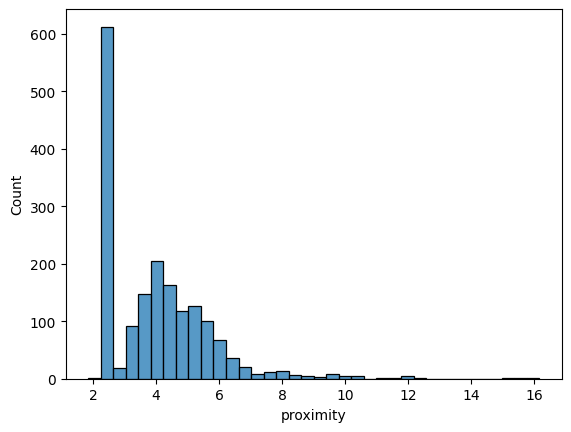

In [11]:
success_results = results[results.success == 1]
sns.histplot(success_results, x='proximity')

# Density

FACE returns high-density results

<Axes: xlabel='poi_density', ylabel='Count'>

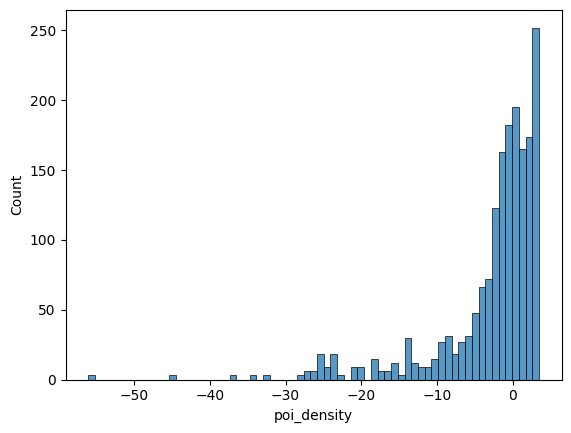

In [12]:
sns.histplot(success_results, x='poi_density')

<Axes: xlabel='cfe_density', ylabel='Count'>

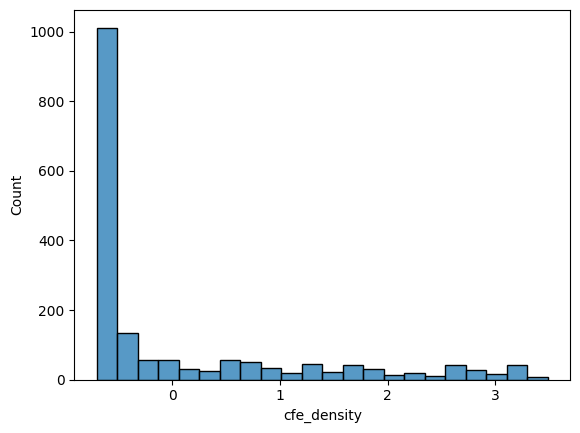

In [13]:
sns.histplot(success_results, x='cfe_density')